In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import cPickle as pickle
import nolearn
import nolearn.lasagne
import lasagne.layers
from ml_helpers import minibatch_generators as mbg
import numpy as np
base = '/media/michael/Seagate/engage/urban8k/'

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5004)
/home/michael/anaconda/lib/python2.7/site-packages/Theano-0.9.0.dev1-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [7]:
# loading data
folds = {}
for fold in range(1, 11):
    loadpath = base + 'specs_no_log/fold%d.pkl' % fold
    folds[fold] = pickle.load(open(loadpath))

In [8]:
def mean_normalise(X):
    med = np.mean(X.reshape(X.shape[0], -1), 1)
    med[med==0] = 0.0001
    return X / med[:, None, None, None]

def med_subtract(X):
    med = np.median(X, 3)
    return X - med[:, :, None, :]
    

splits = {'train': [1, 2, 3, 4, 5, 6, 7, 8, 10], 'val': [9], 'test': [10]}

data = {'train': {'X': [], 'y': []}, 
        'val': {'X': [], 'y': []}, 
        'test': {'X': [], 'y': []}}

for key, val in splits.iteritems():
    for fold_id in val:
        data[key]['X'] += folds[fold_id]['X']
        data[key]['y'] += list(folds[fold_id]['classID'])

    data[key]['X'] = mbg.form_correct_shape_array(data[key]['X'])
    data[key]['y'] = np.array(data[key]['y']).astype(np.int32)
    data[key]['X'] = mean_normalise(data[key]['X'])
    
#     # now do different combinations of channels normalised differently
#     mean_norm = mean_normalise(data[key]['X'])
#     med_subt = med_subtract(data[key]['X'])
#     original = data[key]['X']
#     data[key]['X'] = np.concatenate(1, (mean_norm, med_subt, original))
    data[key]['X'] = data[key]['X'].astype(np.float32)

(1, 224, 224)
-0.1


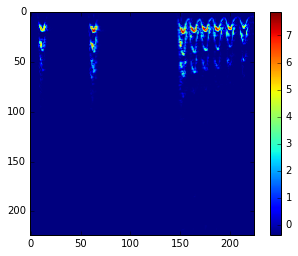

In [47]:

# mapper = {0:0, 7:1, 4:2}
# for fold in data:
#     y = data[fold]['y']
#     idxs = np.logical_or.reduce((y==0, y==4, y==7))
#     data[fold]['X'] = data[fold]['X'][idxs]
#     data[fold]['y'] = np.array([mapper[y] for y in data[fold]['y'][idxs]]).astype(np.int32)
# print data[fold]['y']
xx = data['train']['X'][0]
print xx.shape
xx = xx-0.1
plt.imshow(np.log(0.85 + 1.5*xx[0]))
print xx.min()
plt.colorbar()

In [5]:
import librosa
mel_filts = librosa.filters.mel(44000, n_fft=2*224, n_mels=128).astype(np.float32)
print mel_filts.shape

(128, 225)


/home/michael/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [50]:
import theano.tensor as T

class Log1Plus(lasagne.layers.Layer):
    def __init__(self, incoming, off=lasagne.init.Constant(1.0), mult=lasagne.init.Constant(1.0), **kwargs):
        super(Log1Plus, self).__init__(incoming, **kwargs)
        self.off = self.add_param(off, shape=(1,), name='off')
        self.mult = self.add_param(mult, shape=(1,), name='mult')
        
    def get_output_for(self, input, **kwargs):
        return T.log(self.off.dimshuffle('x', 0, 'x', 'x') + self.mult.dimshuffle('x', 0, 'x', 'x') * input)
    
    def get_output_shape_for(self, input_shape):
        return input_shape

In [51]:
from lasagne.layers import InputLayer, DimshuffleLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
import librosa
import theano
mel_filts = librosa.filters.mel(44000, n_fft=2*224, n_mels=128).astype(np.float32)[:, :-1]
mel_init = theano.shared(mel_filts[:, None, None, :])

net = {}

net['input'] = InputLayer((None, 1, 224, 224))
net['input2'] = PoolLayer(net['input'], 2, mode='average_inc_pad')
net['input_logged'] = Log1Plus(net['input2'])


# fake mel
#net['conv1_0'] = ConvLayer(
#    net['input_logged'], 128, (1, 224), nonlinearity=None, b=None, W=mel_init)
#net['conv1_0_dimshuffled'] = DimshuffleLayer(net['conv1_0'], (0, 3, 1, 2))

# full-height filter
# net['conv1_1'] = ConvLayer(net['conv1_0_dimshuffled'], 128, (128, 3), nonlinearity=vlr)
# net['conv1_1_dimshuffled'] = DimshuffleLayer(net['conv1_1'], (0, 2, 1, 3))

#net['conv1_1'] = ConvLayer(net['conv1_0_dimshuffled'], 32, 3, nonlinearity=vlr)

net['conv1_1'] = ConvLayer(net['input_logged'], 32, 3, nonlinearity=vlr)
# net['pool0'] = PoolLayer(net['conv1_0'], 2, mode='average_inc_pad')
net['conv1_2'] = ConvLayer(net['conv1_1'], 32, 3, nonlinearity=vlr)
net['pool1'] = PoolLayer(net['conv1_2'], 4)

net['conv2_1'] = ConvLayer(net['pool1'], 32, 3, nonlinearity=vlr)
net['conv2_2'] = ConvLayer(net['conv2_1'], 32, 3, nonlinearity=vlr)
net['pool2'] = PoolLayer(net['conv2_2'], 4)

# net['conv3_1'] = ConvLayer(net['pool2'], 32, 3, pad=1, flip_filters=False)
# net['conv3_2'] = ConvLayer(net['conv3_1'], 32, 3, pad=1, flip_filters=False)
net['fc6'] = DenseLayer(net['pool2'], num_units=256, nonlinearity=vlr)
net['fc6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6'], num_units=256, nonlinearity=vlr)
net['fc7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7'], num_units=10, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

In [52]:
# setting up network
class MyTrainSplit(nolearn.lasagne.TrainSplit):
    # custom data split
    def __call__(self, data, Yb, net):
        return data['train']['X'], data['val']['X'], data['train']['y'], data['val']['y']

def augment(X):
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 0.01
        X[idx] *= mult
        X[idx] += add
        if np.random.rand() > 0.9:
            shift = np.random.randint(0, 224)
            X[idx, 0] = np.roll(X[idx, 0], shift, 1)
        
    return X
    
class MyBatch(nolearn.lasagne.BatchIterator):
    def transform(self, Xb, yb):
        return augment(Xb), yb

    def __iter__(self):
        bs = self.batch_size
        for batch_idxs in mbg.minibatch_idx_iterator(
                self.y, bs, randomise=1, balanced=1):

            Xb = self.X[batch_idxs]
            yb = self.y[batch_idxs]
            yield self.transform(Xb, yb)
    

network = nolearn.lasagne.NeuralNet(
    layers=net['prob'],
    max_epochs=500,
    update=lasagne.updates.adam,
    update_learning_rate=0.001,
    verbose=1,
    train_split=MyTrainSplit(None),
    batch_iterator_train=MyBatch(batch_size=64)
)

network.initialize()

In [33]:
# training
# network.load_params_from('mel_fake_full_71%.pkl'),

network.fit(data, None)

# Neural Network with 301484 learnable parameters

## Layer information

  #    name  size
---  ------  ----------
  0          1x224x224
  1          1x112x112
  2          1x112x112
  3          32x110x110
  4          32x108x108
  5          32x27x27
  6          32x25x25
  7          32x23x23
  8          32x5x5
  9          256
 10          256
 11          256
 12          256
 13          10
 14          10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       1.39223       1.04332      1.33443      0.63542  22.89s
      2       0.90274       0.86639      1.04195      0.70685  22.87s
      3       0.70642       0.88448      0.79869      0.71540  22.84s
      4       0.58429       0.92715      0.63021      0.75260  22.83s
      5       0.50024       0.98416      0.50829      0.76265  22.86s
      6       0.43007       1.01040      0.42564      0.73475  22.84s
      7       0.38204   

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fb788a75710>,
     batch_iterator_train=<__main__.MyBatch object at 0x7fb6fddf98d0>,
     check_input=True, custom_epoch_scores=None, custom_scores=None,
     layers=[<lasagne.layers.special.NonlinearityLayer object at 0x7fb70a67be90>],
     loss=None, max_epochs=500, more_params={},
     objective=<function objective at 0x7fb788a77de8>,
     objective_loss_function=<function categorical_crossentropy at 0x7fb789173c08>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7fb70a75fcb0>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7fb70a75fbd8>],
     regression=False,
     train_split=<__main__.MyTrainSplit object at 0x7fb6fcc16fd0>,
     update=<function adam at 0x7fb7891889b0>, update_learning_rate=0.001,
     use_label_encoder=False, verbose=1,
     y_tensor_type=Tens

In [22]:
a = lasagne.layers.get_all_params(network.layers)[0]
print a.get_value()
network.

[ 0.85729277]


In [35]:
# network.save_params_to('75%_acc_5463427b.pkl')
# network.save_params_to('mel_fake_70%.pkl')

from sklearn.metrics import confusion_matrix
from ml_helpers.evaluation import plot_confusion_matrix

tmp = pickle.load(open(loadpath))
mapper = dict(zip(tmp['classID'], tmp['class']))
print mapper
cls_labels = [mapper[xx] for xx in range(10)]#[0, 4, 7]]
print cls_labels

y_pred = network.predict(data['val']['X'])

{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}
['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


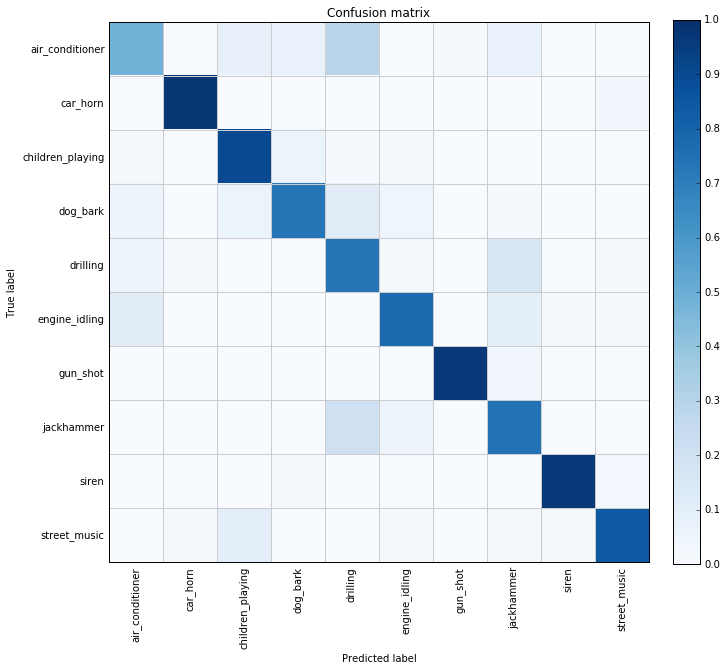

In [36]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(data['val']['y'], y_pred, normalise=1,
        cls_labels=cls_labels)

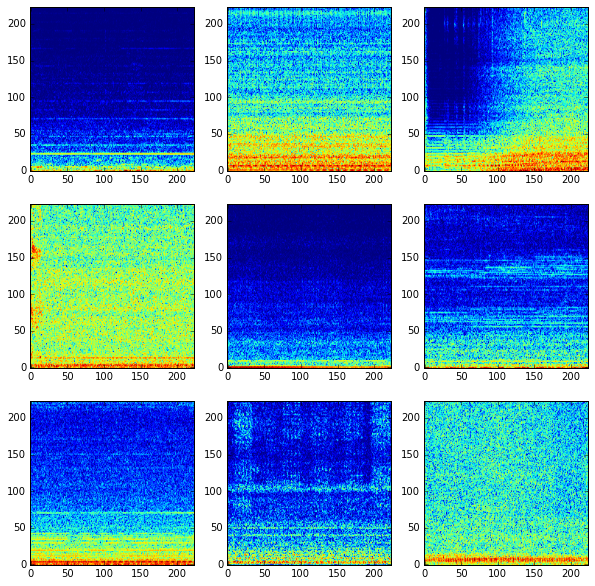

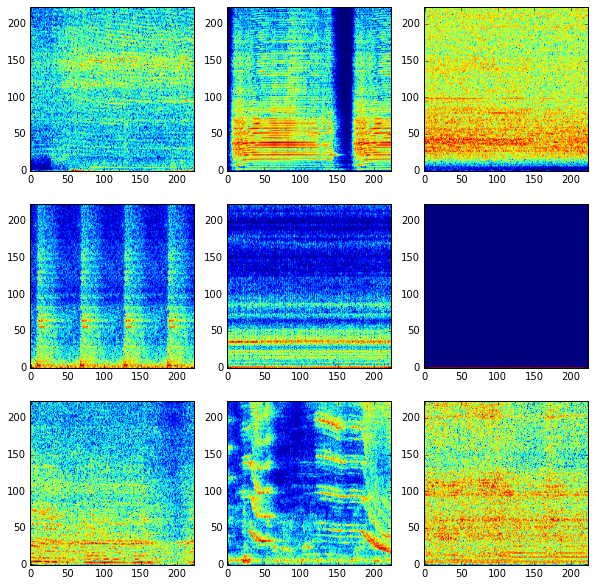

In [82]:
scale = 0
# network.save_params_to('mel_fake_full_71%.pkl')
plt.figure(figsize=(10, 10))
idxs = np.where(data['train']['y'] == 0)[0]
import random
random.shuffle(idxs)
for idx, xx in enumerate(data['train']['X'][idxs][:9]):
    plt.subplot(3, 3, idx+1)
    plt.imshow(xx[0])
    plt.gca().invert_yaxis()
    if scale: plt.clim(0, 3)
    
# network.save_params_to('mel_fake_full_71%.pkl')
plt.figure(figsize=(10, 10))
idxs = np.where(data['train']['y'] == 2)[0]
random.shuffle(idxs)
for idx, xx in enumerate(data['train']['X'][idxs][:9]):
    plt.subplot(3, 3, idx+1)
    plt.imshow(xx[0])
    plt.gca().invert_yaxis()
    if scale: plt.clim(0, 3)

In [91]:
preds = network.predict_proba(data['val']['X'])

In [111]:
baddest = np.where(np.logical_and(data['val']['y'] == 0, preds[:, 1] > 0.9))[0]
print baddest

[  0   2   3  16  23 217 218 219 221 222 224 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267]


In [131]:
import pandas as pd
base = '/media/michael/Seagate/engage/urban8k/UrbanSound8K/audio/'
metadata = pd.read_csv(base + '../metadata/UrbanSound8K.csv')
tmp = metadata[metadata.fold==9]
to_use = tmp[tmp['classID'] == 0]
to_use = tmp.iloc[0]['slice_file_name']
print tmp.iloc[0]['class']

air_conditioner


In [2]:
import IPython
path = base + 'fold%d/%s' % (9, to_use)
IPython.display.Audio(path)

NameError: name 'base' is not defined

In [72]:
xx = np.random.rand(10, 10, 10, 10)
print xx.min(), xx.max(), xx.mean()
augment(xx)
print xx.min(), xx.max(), xx.mean()
augment(xx)
print xx.min(), xx.max(), xx.mean()

7.26285782405e-05 0.999527141079 0.504229282659
-0.0170941993097 1.14462453554 0.504514323291
-0.0273329347982 1.23120310262 0.501863850787


(7906, 1, 224, 224)
88.515184164
15.7155988216
52.7507109642


KeyboardInterrupt: 

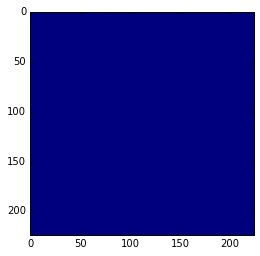

In [90]:

def augment_old(X):
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 0.02
        X[idx] *= mult
        X[idx] += add

        if np.random.rand() > 0.9:
            shift = np.random.randint(0, 224)
            X[idx, 0] = np.roll(X[idx, 0], shift, 1)

    X[X<0.0] = 0.0
    return X
    
def augment_exp(X):
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 0.02
        exp = np.random.rand() + 0.5
        X[idx] = X[idx]**exp
        X[idx] *= mult
        X[idx] += add

        if np.random.rand() > 0.9:
            shift = np.random.randint(0, 224)
            X[idx, 0] = np.roll(X[idx, 0], shift, 1)

    X[X<0.0] = 0.0
    return X
    

def augment_new(X):
    newX = np.zeros_like(X)
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 0.02
        exp = np.random.rand() + 0.5
        newX[idx] = X[idx]**exp
        newX[idx] *= mult
        newX[idx] += add

        if np.random.rand() > 0.9:
            shift = np.random.randint(0, 224)
            newX[idx, 0] = np.roll(newX[idx, 0], shift, 1)

    newX[newX<0.0] = 0.0
    return newX

xx = data['train']['X'][10:]
print xx.shape

from time import time

tic = time()
for _ in range(1): 
    augment_new(xx)
print time() - tic


tic = time()
for _ in range(1): 
    augment_old(xx)
print time() - tic

tic = time()
for _ in range(1): 
    augment_exp(xx)
print time() - tic

plot_spec(xx)
augment_new(xx)
plot_spec(xx)
augment_new(xx)
plot_spec(xx)
augment_new(xx)
plot_spec(xx)
augment_new(xx)



9.23766
1.09168219566


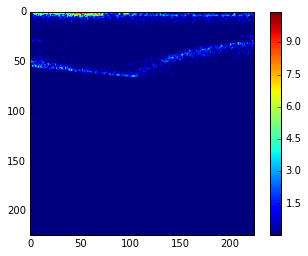

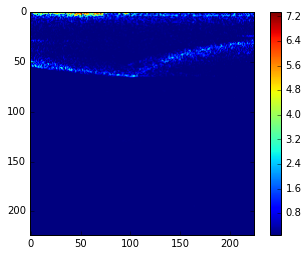

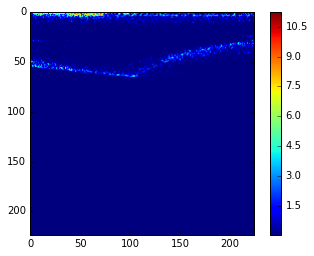

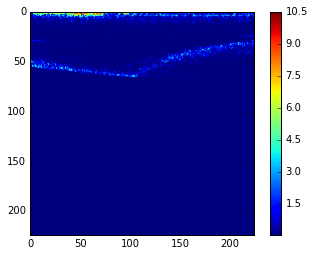

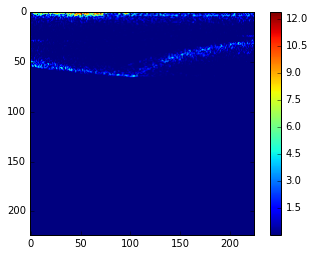

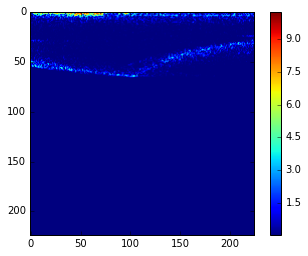

In [222]:
def plot_spec(x):
    plt.figure()
    plt.imshow(np.log(1.0 + x[0, 0]))
    plt.colorbar()

def augment_new(X):
    newX = np.zeros_like(X)
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 1.0
        
        newX[idx] = X[idx] * mult
        newX[idx] += add

        if np.random.rand() > 0.0:
            exp = np.random.randn() * 0.25 + 1.0
            if exp < 0:
                break
            newX[idx] = X[idx]**exp
        
        if 0:#np.random.rand() > 0.9:
            shift = np.random.randint(0, 224)
            newX[idx, 0] = np.roll(newX[idx, 0], shift, 1)
       
    newX[newX<-0.1] = 0.1
    return newX

tic = time()
print xx.mean()
xx = data['train']['X'][100:101]

plot_spec(xx[:1])
xt = augment_new(xx)
plot_spec(xt[:1])
xt = augment_new(xx)
plot_spec(xt[:1])
xt = augment_new(xx)
plot_spec(xt[:1])
xt = augment_new(xx)
plot_spec(xt[:1])
xt = augment_new(xx)
plot_spec(xt[:1])

print time() - tic


In [221]:
exp = np.random.randn(100000) * 0.25 + 1.0
exp.min()
print (exp<0.0).sum()

1


In [226]:
for idx in range(1, 11):
    print "(%d, %d)," % (idx, idx+1),

(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11),


In [227]:

for val, test in ((1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 1)):

    print set(range(1, 11)) - set((val, test))

set([3, 4, 5, 6, 7, 8, 9, 10])
set([1, 4, 5, 6, 7, 8, 9, 10])
set([1, 2, 5, 6, 7, 8, 9, 10])
set([1, 2, 3, 6, 7, 8, 9, 10])
set([1, 2, 3, 4, 7, 8, 9, 10])
set([1, 2, 3, 4, 5, 8, 9, 10])
set([1, 2, 3, 4, 5, 6, 9, 10])
set([1, 2, 3, 4, 5, 6, 7, 10])
set([1, 2, 3, 4, 5, 6, 7, 8])
set([2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
data